## Data processing for dashboard

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
from datetime import datetime

#import matplotlib.pyplot as plt
#import seaborn as sns

#from sklearn.preprocessing import MinMaxScaler
#import geopandas as gpd

## Read in and process dependent variable - turnover

Read turnover data from csv into a dataframe.

In [2]:
# annual and monthly data

annual_url = '../01_data/processed_annual_turnover.csv'
#monthly_url = '../01_data/processed_monthly_turnover.csv'

annual_df = pd.read_csv(annual_url, parse_dates=['month_year'])
annual_df = annual_df.drop(['n'],axis=1)
#annual_df.info()

#monthly_df = pd.read_csv(monthly_url, parse_dates=['month_year'])
#monthly_df = monthly_df.drop(['n'],axis=1)
annual_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191090 entries, 0 to 191089
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   org_code           191090 non-null  object        
 1   region_name        191090 non-null  object        
 2   org_type           191090 non-null  object        
 3   staff_group        191090 non-null  object        
 4   month_year         191090 non-null  datetime64[ns]
 5   join_HC            145550 non-null  float64       
 6   join_FTE           145550 non-null  float64       
 7   leave_HC           147697 non-null  float64       
 8   leave_FTE          147697 non-null  float64       
 9   denom_HC           186640 non-null  float64       
 10  denom_FTE          186640 non-null  float64       
 11  start_date         191090 non-null  object        
 12  denom_FTE_start    155299 non-null  float64       
 13  denom_HC_start     155299 non-null  float64 

Function to clean and process DV dataframes

In [3]:
def clean_dv(df):
    # drop org_type because it has historic variation which is creating duplicates when mapping later
    df.drop('org_type', axis=1, inplace=True) 
    # add leaver and joiner rates column
    df['leaver_rate'] = df['leave_FTE']/df['denom_FTE_average']
    df['joiner_rate'] = df['join_FTE']/df['denom_FTE_average']

    # replace inf values with nan (can happen with rate calcs)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

In [4]:
annual_df1 = clean_dv(annual_df)
#monthly_df1 = clean_dv(monthly_df)

In [5]:
annual_df1 = annual_df1.sort_values(by='month_year')

In [6]:
# cut first year of dataframe as this only contains start denoms values
annual_df2 = annual_df1[annual_df1['month_year'] >= (annual_df1['month_year'].min()) + pd.DateOffset(years=1)]

In [7]:
annual_df2.head()

,org_code,region_name,staff_group,month_year,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE,start_date,denom_FTE_start,denom_HC_start,denom_FTE_average,denom_HC_average,leaver_rate,joiner_rate
34348,RD3,South West,Nurses & health visitors,2018-08-01,86.0,79.47998,120.0,107.41331,926.0,823.55901,2017-08-01,856.55941,954.0,840.059210,940.0,0.127864,0.094612
184545,RYR,South East,Support to ST&T staff,2018-08-01,78.0,65.95599,55.0,47.95334,556.0,467.35279,2017-08-01,453.22292,532.0,460.287855,544.0,0.104181,0.143293
108084,RRF,North West,"Support to doctors, nurses & midwives",2018-08-01,140.0,102.98660,125.0,92.17677,1670.0,1322.61027,2017-08-01,1333.83093,1673.0,1328.220600,1671.5,0.069399,0.077537
139517,RWF,South East,Nurses & health visitors,2018-08-01,129.0,117.08398,162.0,144.30668,1316.0,1158.51170,2017-08-01,1185.94888,1345.0,1172.230290,1330.5,0.123104,0.099881
135866,RW6,North West,Midwives,2018-08-01,44.0,42.50666,41.0,33.70668,393.0,347.76044,2017-08-01,341.67710,391.0,344.718770,392.0,0.097780,0.123308


The data show the full time equivalent (FTE) and headcount (HC) number of leavers by organisation and staff group for the previous 12-month period from the date.

In [8]:
annual_df2['staff_group'].unique()

array(['Nurses & health visitors', 'Support to ST&T staff',
       'Support to doctors, nurses & midwives', 'Midwives',
       'HCHS doctors (exc. junior Drs)', 'Central functions',
       'All staff groups', 'Senior managers',
       'Scientific, therapeutic & technical staff',
       'Hotel, property & estates', 'Ambulance staff', 'Managers',
       'Other staff or those with unknown classification',
       'Support to ambulance staff'], dtype=object)

## Load independent variable 1 - local unemployment

Load data about local unemployment.

In [9]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

#df_r1.drop(['thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.tail()

,month_year,region_name,local_unemployment
2619,2023-06-01,London,0.0480
2620,2023-06-01,Midlands,0.0455
2621,2023-06-01,North East,0.0520
2622,2023-06-01,North West,0.0530
2624,2023-06-01,South West,0.0360


## Load IV 2 - sickness absence

Load data about sickness absence to use as second regressor

In [10]:
url_r2 = '../01_data/data_wrangling/sickness_benchmarking.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['DATE'])

In [11]:
df_r2['BENCHMARK_GROUP'].unique()

array(['Ambulance Trust', 'Acute - Teaching',
       'Mental Health and Learning Disability', 'Acute - Large',
       'Acute - Small', 'Care Trust', 'Acute - Specialist', 'Others',
       'Acute - Medium', 'Community Provider Trust',
       'Integrated Care Board', 'Clinical Commissioning Group',
       'Acute - Multi-Service', 'Commissioning Support Unit'],
      dtype=object)

In [12]:
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['CLUSTER_GROUP'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['BENCHMARK_GROUP','ORG_NAME',
                    'NHSE_REGION_CODE','CLUSTER_GROUP','file_date'],axis=1)
df_r2.rename(columns={'ORG_CODE':'org_code','DATE':'month_year',
                      'NHSE_REGION_NAME':'region_name','STAFF_GROUP':'staff_group',
                      'FTE_DAYS_LOST':'fte_days_lost','FTE_DAYS_AVAILABLE':'fte_days_available'},inplace=True)
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_r2['sickness_absence'] = df_r2['fte_days_lost']/df_r2['fte_days_available']
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192606 entries, 0 to 192605
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          192606 non-null  datetime64[ns]
 1   staff_group         192606 non-null  object        
 2   org_code            192606 non-null  object        
 3   region_name         192606 non-null  object        
 4   fte_days_lost       166612 non-null  float64       
 5   fte_days_available  166612 non-null  float64       
 6   sickness_absence    166358 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 10.3+ MB


In [13]:
df_r2.tail()

,month_year,staff_group,org_code,region_name,fte_days_lost,fte_days_available,sickness_absence
192601,2018-04-30,Central functions,8JX76,Special Health Authorities and other statutory...,NaN,NaN,NaN
192602,2018-04-30,"Hotel, property & estates",8JX76,Special Health Authorities and other statutory...,72.19999,844.68052,0.085476
192603,2018-04-30,Other staff or those with unknown classification,8JX76,Special Health Authorities and other statutory...,NaN,NaN,NaN
192604,2018-03-31,All staff groups,8JX76,Special Health Authorities and other statutory...,NaN,NaN,NaN
192605,2018-03-31,Other staff or those with unknown classification,8JX76,Special Health Authorities and other statutory...,NaN,NaN,NaN


Create 12-month rolling sickness absence column for use with annual turnover data

In [14]:
df_r2['month_year'] = pd.to_datetime(df_r2['month_year'])

# Sort the DataFrame by organisation, staff_group, and month
df_r2.sort_values(by=['org_code', 'staff_group', 'month_year'], inplace=True)

# Calculate the rolling sums for days lost and days available
df_r2['rolling_days_lost'] = df_r2.groupby(['org_code', 
                        'staff_group'])['fte_days_lost'].rolling(window=12, min_periods=1).sum().reset_index(level=[0, 1], drop=True)

df_r2['rolling_days_available'] = df_r2.groupby(['org_code', 
                        'staff_group'])['fte_days_available'].rolling(window=12, min_periods=1).sum().reset_index(level=[0, 1], drop=True)

# Calculate the rolling sickness absence rate
df_r2['annual_sickness_absence'] = df_r2['rolling_days_lost'] / df_r2['rolling_days_available']

# drop fte_days_lost fte_days_available, rolling_days_available and rolling_days_lost columns
#df_r2.drop(columns=['fte_days_lost', 'fte_days_available', 'rolling_days_available', 'rolling_days_lost'], inplace=True)

df_r2.head()

,month_year,staff_group,org_code,region_name,fte_days_lost,fte_days_available,sickness_absence,rolling_days_lost,rolling_days_available,annual_sickness_absence
187947,2018-03-31,All staff groups,0AR,Special Health Authorities and other statutory...,945.49965,30791.10395,0.030707,945.49965,30791.10395,0.030707
187940,2018-04-30,All staff groups,0AR,Special Health Authorities and other statutory...,1140.45017,29992.67742,0.038024,2085.94982,60783.78137,0.034318
187933,2018-05-31,All staff groups,0AR,Special Health Authorities and other statutory...,1248.35313,31421.30422,0.039730,3334.30295,92205.08559,0.036162
187925,2018-06-30,All staff groups,0AR,Special Health Authorities and other statutory...,996.38655,30107.93421,0.033094,4330.68950,122313.01980,0.035407
187917,2018-07-31,All staff groups,0AR,Special Health Authorities and other statutory...,994.07992,31366.84421,0.031692,5324.76942,153679.86401,0.034648


In [15]:
a = sorted(df_r2['staff_group'].unique())
a


['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [16]:
b = []
len(b)

0

In [17]:
# Get the top 4 staff groups based on average absence rate
top_staff_groups = df_r2.groupby('staff_group')['sickness_absence'].mean().nlargest(4).index

# Filter the DataFrame for the top 4 staff groups
top_groups_df = df_r2[df_r2['staff_group'].isin(top_staff_groups)]

# Pivot the DataFrame to have staff groups as columns
pivoted_df = top_groups_df.pivot_table(index='month_year', columns='staff_group', values='sickness_absence', aggfunc='mean')

In [18]:
pivoted_df

staff_group,Ambulance staff,"Hotel, property & estates",Support to ambulance staff,"Support to doctors, nurses & midwives"
month_year,,,,
2018-03-31,0.048738,0.052638,0.062738,0.055472
2018-04-30,0.054370,0.048784,0.057447,0.052991
2018-05-31,0.051562,0.049748,0.057869,0.052923
2018-06-30,0.049679,0.054348,0.063988,0.054666
2018-07-31,0.052650,0.056554,0.069925,0.057242
...,...,...,...,...
2023-02-28,0.064239,0.066156,0.079303,0.066286
2023-03-31,0.065399,0.065032,0.077343,0.066122
2023-04-30,0.057830,0.060727,0.071775,0.060047


In [19]:
df_r2.groupby(['month_year', 'staff_group'])['sickness_absence'].mean().reset_index()

,month_year,staff_group,sickness_absence
0,2018-03-31,All staff groups,0.041361
1,2018-03-31,Ambulance staff,0.048738
2,2018-03-31,Central functions,0.032866
3,2018-03-31,HCHS doctors (exc. junior Drs),0.018437
4,2018-03-31,"Hotel, property & estates",0.052638
...,...,...,...
891,2023-06-30,"Scientific, therapeutic & technical staff",0.032742
892,2023-06-30,Senior managers,0.015804
893,2023-06-30,Support to ST&T staff,0.049119
894,2023-06-30,Support to ambulance staff,0.075792


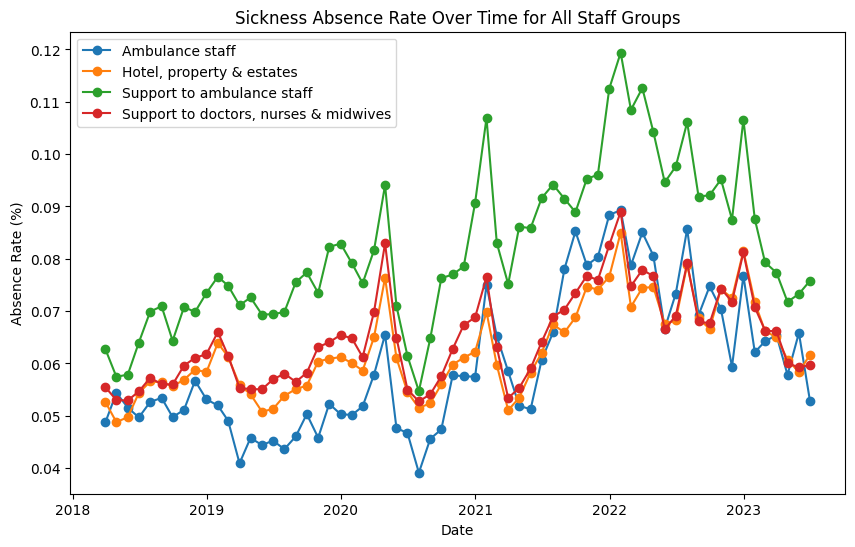

In [20]:
import matplotlib.pyplot as plt

# Plotting each staff group as a separate line
plt.figure(figsize=(10, 6))

for staff_group in pivoted_df.columns:
    plt.plot(pivoted_df.index, pivoted_df[staff_group], marker='o', linestyle='-', label=staff_group)

plt.title('Sickness Absence Rate Over Time for All Staff Groups')
plt.xlabel('Date')
plt.ylabel('Absence Rate (%)')
plt.legend()
plt.show()

## Load IV 3 - reasons for sickness absence

Add data about reasons for sickness absence

In [21]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# drop least frequent reasons for absence
df_r3 = df_r3.drop(['substance_abus','asthma',
                    'dental','blood_disorder','endocrine',
                    'eye','skin_disorders','nervous_system'],axis=1)

# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()
# national level data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413 entries, 0 to 1412
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1413 non-null   datetime64[ns]
 1   staff_group        1413 non-null   object        
 2   anxiety_stress     1413 non-null   float64       
 3   back_problems      1413 non-null   float64       
 4   gastro             1413 non-null   float64       
 5   gynaecological     1413 non-null   float64       
 6   headache_mig       1413 non-null   float64       
 7   infectious_dis     1413 non-null   float64       
 8   other              1413 non-null   float64       
 9   other_msk          1413 non-null   float64       
 10  pregnancy_related  1413 non-null   float64       
 11  respiratory        1413 non-null   float64       
 12  unknown            1413 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 143.

In [22]:
df_r3.tail()

,month_year,staff_group,anxiety_stress,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
1408,2022-06-01,"Scientific, therapeutic & technical staff",0.299827,0.039535,0.102062,0.042492,0.034684,0.112587,0.073708,0.086431,0.038768,0.093175,0.032900
1409,2022-06-01,Senior managers,0.381579,0.032083,0.050199,0.025234,0.015957,0.079350,0.138571,0.033597,0.023071,0.094360,0.088860
1410,2022-06-01,Support to ST&T staff,0.312630,0.057006,0.103472,0.033756,0.035771,0.083623,0.075481,0.108540,0.022243,0.081857,0.031112
1411,2022-06-01,Support to ambulance staff,0.319816,0.080901,0.098365,0.027831,0.031204,0.104323,0.056427,0.094098,0.020951,0.077216,0.042403
1412,2022-06-01,"Support to doctors, nurses & midwives",0.311573,0.065024,0.097089,0.042193,0.027871,0.070502,0.076314,0.125198,0.029533,0.071209,0.030315


## Load IV 4 and 5 - staff vacancies

In [23]:
url_sg_ref = '../01_data/ref_sg_vacancy.csv'
df_sg_ref = pd.read_csv(url_sg_ref)
df_sg_ref.head()

,staff_group,vacancy_sg,all
0,Ambulance staff,Allied Health Professionals,All staff groups
1,Central functions,Administrative and Clerical,All staff groups
2,HCHS doctors (exc. junior Drs),Medical and Dental,All staff groups
3,"Hotel, property & estates",Estates and Ancillary,All staff groups
4,Managers,Administrative and Clerical,All staff groups


In [24]:
url_r4 = '../01_data/vacancy_ESR.csv'
df_r4 = pd.read_csv(url_r4,parse_dates=['month_year'],dayfirst=True)

df_r4 = df_r4.drop(['Published month','Published quarter','England'],axis=1)
df_r4.rename(columns={'NWD Staff Group':'vacancy_sg','NHS England region':'region_name',
                        'Vacancy Wte':'vacancy_FTE'},inplace=True)

df_r4 = df_r4.fillna(0)

# Remove code in brackets
df_r4['region_name'] = df_r4['region_name'].str[:-6].str.rstrip()

# Add staff groupings to match other datasets
df_r4 = pd.merge(df_r4, df_sg_ref, on='vacancy_sg',how='left')

df_r4 = df_r4.drop(['all'],axis=1)

df_r4.info()

# regional level

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8387 entries, 0 to 8386
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   month_year   8387 non-null   datetime64[ns]
 1   vacancy_sg   8387 non-null   object        
 2   region_name  8387 non-null   object        
 3   vacancy_FTE  8387 non-null   float64       
 4   staff_group  7948 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 327.7+ KB


In [25]:
url_r5 = '../01_data/vacancy_TRAC.csv'
df_r5 = pd.read_csv(url_r5,parse_dates=['month_year'],dayfirst=True)

df_r5 = df_r5.drop(['Published month','Published quarter','England'],axis=1)

df_r5.rename(columns={'NWD Staff Group':'vacancy_sg','NHS England region':'region_name',
                        'Advertised FTE':'advertised_FTE'},inplace=True)

df_r5 = df_r5.fillna(0)

# Remove region code in brackets
df_r5['region_name'] = df_r5['region_name'].str[:-6].str.rstrip()

# Add staff groupings to match other datasets
df_r5 = pd.merge(df_r5, df_sg_ref, on='vacancy_sg',how='left')

df_r5 = df_r5.drop(['all'],axis=1)

# regional level

df_r5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   month_year      4226 non-null   datetime64[ns]
 1   vacancy_sg      4226 non-null   object        
 2   region_name     4226 non-null   object        
 3   advertised_FTE  4226 non-null   float64       
 4   staff_group     3999 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 165.2+ KB


## Load IV 6 - Reasons for leaving

Data are only quarterly

In [26]:
url_r6 = '../01_data/rfl_dec22.csv'
df_r6 = pd.read_csv(url_r6,parse_dates=['month_year'],dayfirst=True)

#df_r6 = df_r6.drop(['financial_year','quarter'],axis=1)

# df_r5.rename(columns={'NWD Staff Group':'staff_group','NHS England region':'region_name',
#                         'Advertised FTE':'advertised_FTE'},inplace=True)

# df_r5 = df_r5.fillna(0)

# # Remove region code in brackets
# df_r5['region_name'] = df_r5['region_name'].str[:-6].str.rstrip()
# # regional level

# shortern column names and add %_ at beginning
df_r6.rename(columns={'Death in service':'%_death_in_service','Dismissal':'%_dismissal',
                        'End of fixed term':'%_end_of_ft','Flexibility':'%_flexibility',
                        'Health':'%_health','Incompatible working relationships':'%_incompat_relations',
                        'Other':'%_other', 'Pay/Reward':'%_pay_reward', 'Pregnancy':'%_pregnancy',
                        'Progression/CPD':'%_progression_cpd','Relocation':'%_relocation',
                        'Retirement':'%_retirement','Unknown':'%_unknown','Work/Life Balance':'%_work_life_balance',
                        'Workforce Transformation':'%_workforce_transform'},inplace=True)

df_r6['%_other'] = pd.to_numeric(df_r6['%_other'], errors='coerce')
df_r6['%_unknown'] = pd.to_numeric(df_r6['%_unknown'], errors='coerce')
df_r6['%_workforce_transform'] = pd.to_numeric(df_r6['%_workforce_transform'], errors='coerce')

df_r6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   month_year             20 non-null     datetime64[ns]
 1   %_death_in_service     20 non-null     float64       
 2   %_dismissal            20 non-null     float64       
 3   %_end_of_ft            20 non-null     float64       
 4   %_flexibility          20 non-null     float64       
 5   %_health               20 non-null     float64       
 6   %_incompat_relations   20 non-null     float64       
 7   %_other                17 non-null     float64       
 8   %_pay_reward           20 non-null     float64       
 9   %_pregnancy            20 non-null     int64         
 10  %_progression_cpd      20 non-null     float64       
 11  %_relocation           20 non-null     float64       
 12  %_retirement           20 non-null     float64       
 13  %_unkno

## Merge IV dfs to main df

In [27]:
annual_df1.head()

,org_code,region_name,staff_group,month_year,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE,start_date,denom_FTE_start,denom_HC_start,denom_FTE_average,denom_HC_average,leaver_rate,joiner_rate
43012,REN,North West,"Support to doctors, nurses & midwives",2017-08-01,NaN,NaN,NaN,NaN,289.0,250.62533,2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN
103733,RQY,London,Central functions,2017-08-01,NaN,NaN,NaN,NaN,129.0,121.88534,2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN
25046,RBS,North West,Central functions,2017-08-01,NaN,NaN,NaN,NaN,350.0,301.73382,2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN
103805,RQY,London,HCHS doctors (exc. junior Drs),2017-08-01,NaN,NaN,NaN,NaN,135.0,119.00000,2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN
175751,RY8,Midlands,HCHS doctors (exc. junior Drs),2017-08-01,NaN,NaN,NaN,NaN,65.0,42.95302,2016-08-01,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def merge_ivs(df, df_r1, df_r2, df_r3,df_r4,df_r5,df_r6):
    # local unemployment rate
    df1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
    df1 = df1.sort_values('month_year')

    # sickness absence
    r2_merge_cols = ['month_year', 'org_code','region_name','staff_group']
    df2 = pd.merge(df1, df_r2, on=r2_merge_cols,how='left')
    #df2.drop_duplicates(subset=r2_merge_cols)

    # reason for sickness absence
    r3_merge_cols = ['month_year','staff_group']
    df3 = pd.merge(df2, df_r3, on=r3_merge_cols,how='left')

    # vacancy
    r4_merge_cols = ['month_year','region_name','staff_group']

    df4 = pd.merge(df3, df_r4, on=r4_merge_cols,how='left')

    # df4.drop(columns=['vacancy_sg'], inplace=True)

    # df4['vacancy_rate'] = df4['vacancy_FTE'] / df4['sip_FTE_region']

    # advertised vacancy
    df5 = pd.merge(df4, df_r5, on=r4_merge_cols,how='left')

    # df5.drop(columns=['vacancy_sg'], inplace=True)

    # df5['advertised_rate'] = df5['advertised_FTE'] / df5['sip_FTE_region']

    # df5.drop(columns=['sip_FTE_region','advertised_FTE','vacancy_FTE'], inplace=True)

    # reasons for leaving
    df6 = pd.merge(df5, df_r6, on='month_year',how='left')

    # Need to cut dataframe to earliest and latest data available for all fields. Do this by cutting rows where all values for key variables are zero
    df6 = df6[~((df5['leaver_rate'] == 0) | (df6['joiner_rate'] == 0) | (df6['sickness_absence'] == 0))]
    max_date = df6['month_year'].max()
    min_date = df6['month_year'].min()
    # Calculate the difference in months
    delta = relativedelta(max_date, min_date)
    # Extract the number of months
    months_difference = delta.years * 12 + delta.months
    print(f"After trimming, the dataframe ranges from {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}, "
           f"giving {months_difference} months of data")
    # transform nans into 0s
    df6 = df6.fillna(0)

    # drop duplicates
    df6.drop_duplicates(inplace=True)
    
    return df6
#    return max_date

In [29]:
annual_df_ivs = merge_ivs(annual_df1,df_r1, df_r2, df_r3,df_r4,df_r5,df_r6)

After trimming, the dataframe ranges from 2017-08-01 to 2023-07-01, giving 71 months of data


In [30]:
# check sickness_absence

In [31]:
#monthly_df_ivs = merge_ivs(monthly_df1,df_r1, df_r2, df_r3,df_r4,df_r5,df_r6)

In [32]:
annual_df_ivs.tail()

,org_code,region_name,staff_group,month_year,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE,...,%_incompat_relations,%_other,%_pay_reward,%_pregnancy,%_progression_cpd,%_relocation,%_retirement,%_unknown,%_work_life_balance,%_workforce_transform
191085,RH8,South West,All staff groups,2023-07-01,1731.0,1554.67342,1286.0,1048.52686,12526.0,10799.05898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191086,RLQ,Midlands,Senior managers,2023-07-01,2.0,2.00000,1.0,1.00000,31.0,30.20000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191087,RLQ,Midlands,"Scientific, therapeutic & technical staff",2023-07-01,55.0,50.39333,56.0,48.23360,479.0,402.48668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191088,RLQ,Midlands,"Support to doctors, nurses & midwives",2023-07-01,264.0,229.40660,109.0,85.35334,1037.0,861.75182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191089,TAJ,Midlands,"Support to doctors, nurses & midwives",2023-07-01,189.0,168.89761,83.0,71.58666,990.0,865.28291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
annual_df_ivs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191090 entries, 0 to 191089
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   org_code                 191090 non-null  object        
 1   region_name              191090 non-null  object        
 2   staff_group              191090 non-null  object        
 3   month_year               191090 non-null  datetime64[ns]
 4   join_HC                  191090 non-null  float64       
 5   join_FTE                 191090 non-null  float64       
 6   leave_HC                 191090 non-null  float64       
 7   leave_FTE                191090 non-null  float64       
 8   denom_HC                 191090 non-null  float64       
 9   denom_FTE                191090 non-null  float64       
 10  start_date               191090 non-null  object        
 11  denom_FTE_start          191090 non-null  float64       
 12  denom_HC_start  

In [34]:
annual_df_ivs.to_csv(f'annual_dash_data.csv', index=False)

In [35]:
#monthly_df_ivs.to_csv(f'monthly_dash_data.csv', index=False)